In [46]:
import ultralytics
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
import pandas as pd
import json
from ultralytics import YOLO

In [47]:
with open('dataset_astyx_hires2019/dataset_astyx_demo/calibration/000000.json') as f:
   data = json.load(f)
T_lidar_matrix = np.array(data['sensors'][1]['calib_data']['T_to_ref_COS'])
T_camera_matrix = np.array(data['sensors'][2]['calib_data']['T_to_ref_COS'])
K_intrinsic_matrix = np.array(data['sensors'][2]['calib_data']['K'])

# Draw Bounding Boxes

In [48]:
def obtain_bounding_boxes(image):
    
    model = YOLO('Model.pt')
    box = model.predict(image)
    boxes = box[0].boxes.xyxy.tolist()
    for i in boxes:
        x1,y1 = int(i[0]),int(i[1])
        x2,y2 = int(i[2]),int(i[3])
        result = (cv2.rectangle(image,(x1,y1),(x2,y2),(255,255,0),3))
        plt.imshow(result)

In [49]:
camera_image_rgb = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000176.jpg'), cv2.COLOR_BGR2RGB)


0: 256x800 1 Car, 233.4ms
Speed: 5.0ms preprocess, 233.4ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 800)


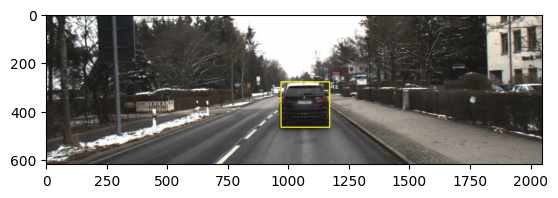

In [50]:
obtain_bounding_boxes(camera_image_rgb)

# Camera and Radar Fusion


0: 256x800 1 Car, 246.3ms
Speed: 2.0ms preprocess, 246.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 800)


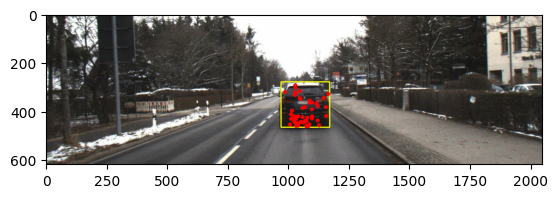

In [26]:
radar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/000176.txt',delim_whitespace=True)
camera_image_rgb = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000176.jpg'), cv2.COLOR_BGR2RGB)

model = YOLO('Model.pt')
box = model.predict(camera_image_rgb)
boxes = box[0].boxes.xyxy.tolist()
points = []
for i in boxes:
        x1,y1 = int(i[0]),int(i[1])
        x2,y2 = int(i[2]),int(i[3])
        image = (cv2.rectangle(camera_image_rgb,(x1,y1),(x2,y2),(255,255,0),3))
for i in range(len(radar_df)):
    x , y, z = radar_df.iloc[i, :3]
    inverted_mat = np.linalg.inv(T_camera_matrix)
    radar_point = np.array([x,y,z,1])
    obj_image = np.dot(inverted_mat, radar_point.T)  # Apply rotation\n",
    obj_image = np.dot(K_intrinsic_matrix, obj_image[:3])  # Apply intrinsic camera matrix\n",
    obj_image = obj_image / obj_image[2]
    x, y = obj_image[0], obj_image[1]
    if x> x1 and x< x2 :
        if y>y1 and y<y2:# Normalize by the third row to project onto image plane\n",
            points.append(obj_image)
    
for i in points:
     x , y = int(i[0]),int(i[1])
     camera_image_rgb = cv2.circle(camera_image_rgb,(x,y),5,(255,0,0),5)
plt.imshow(camera_image_rgb)

# Camera and Lidar Fusion


0: 256x800 1 Car, 180.5ms
Speed: 2.0ms preprocess, 180.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 800)


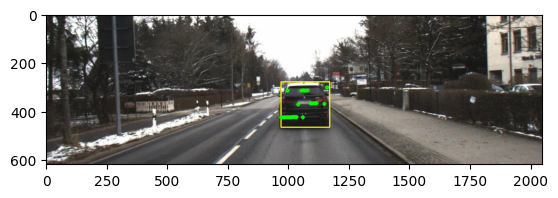

In [27]:
lidar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000176.txt',delim_whitespace=True)
camera_image_rgb = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000176.jpg'), cv2.COLOR_BGR2RGB)
pixel_points =[]
model = YOLO('Model.pt')
box = model.predict(camera_image_rgb)
boxes = box[0].boxes.xyxy.tolist()
for i in boxes:
        x1,y1 = int(i[0]),int(i[1])
        x2,y2 = int(i[2]),int(i[3])
        image = (cv2.rectangle(camera_image_rgb,(x1,y1),(x2,y2),(255,255,0),3))

for i in range(len(lidar_df)):
    x,y,z = lidar_df.iloc[i,:3]
    lidar_point = np.array([x, y, z,1])
    world_point = np.dot(T_lidar_matrix,lidar_point)
    camera_point = np.dot(inverted_mat, lidar_point)  
    pixel_coordinates_homogeneous = np.dot(K_intrinsic_matrix, camera_point[:3])
    pixel_coordinates = pixel_coordinates_homogeneous / pixel_coordinates_homogeneous[2]
    x, y = pixel_coordinates[0], pixel_coordinates[1]

    if x>= x1 and x<= x2 :
        if y>=y1 and y<=y2:
            pixel_points.append(pixel_coordinates)

for i in pixel_points:
     x , y = int(i[0]),int(i[1])
     camera_image_rgb = cv2.circle(camera_image_rgb,(x,y),5,(0,255,0),5)
plt.imshow(camera_image_rgb)

# Camera Lidar Radar Fusion

In [56]:
lidar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000133.txt',delim_whitespace=True)
radar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/000133.txt',delim_whitespace=True)
camera_image_rgb = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000133.jpg'), cv2.COLOR_BGR2RGB)

In [38]:
truck_radar_estimations = []
car_radar_estimations = []

In [55]:
def fuse_camera_lidar_radar(image,lidar_file,radar_file,ID,vehicle):
    global x1,y1,x2,y2,bw,bh
    global X1,Y1,X2,Y2
    
    model = YOLO('Model.pt')
    if vehicle == 'bus' :
        model_classes = 0
    elif vehicle == 'car':
        model_classes = 1
    else :
        model_classes = 2
        
    box = model.predict(image, classes = [model_classes],conf = 0.45 )
    boxes = box[0].boxes.xyxy.tolist()

    for i in boxes:
        x1,y1 = int(i[0]),int(i[1])
        x2,y2 = int(i[2]),int(i[3])
        bw = abs(x1 - x2)
        bh = abs(y1 - y2)
        
        image = (cv2.rectangle(image,(x1,y1),(x2,y2),(255,255,0),3))

    radar_points = []
    filtered_radar_points = []
    
    radar_indexes = []
    radar_distances = [] 
    filtered_radar_distances = []
    
    lidar_indexes = []
    lidar_distances = []
    filtered_lidar_distances = []
    
    for i in range(len(radar_file)):
        x , y, z = radar_file.iloc[i, :3]
        inverted_mat = np.linalg.inv(T_camera_matrix)
        radar_point = np.array([x,y,z,1])
        obj_image = np.dot(inverted_mat, radar_point.T)  # Apply rotation\n",
        obj_image = np.dot(K_intrinsic_matrix, obj_image[:3])  # Apply intrinsic camera matrix\n",
        obj_image = obj_image / obj_image[2]
        A, B = obj_image[0], obj_image[1]

        centroid_x = ( x1 + x2 ) / 2
        centroid_y = (y1 + y2) / 2
        X1 , X2, Y1, Y2 = centroid_x - (bw*0.35), centroid_x + (bw*0.35), centroid_y - (bh*0.35), centroid_y + (bh*0.35) 
        
        if A>= X1 and A<= X2 :
            if B>= Y1  and B<= Y2 :# Normalize by the third row to project onto image plane\n",
                radar_points.append(obj_image)
                radar_indexes.append(i)
        
    for x in radar_indexes:
        distance = radar_file.iloc[x,0]
        radar_distances.append(distance)
    
    for x in radar_distances:
        if x < np.mean(radar_distances):
            point_index = radar_distances.index(x)
            filtered_radar_distances.append(x)
            filtered_radar_points.append(radar_points[point_index])


    for i in filtered_radar_points:
         x , y = int(i[0]),int(i[1])
         image = cv2.circle(image,(x,y),3,(255,0,0),3)
    
    lidar_points = []
    filtered_lidar_points = []
    
    for i in range(len(lidar_file)):
        x,y,z = lidar_file.iloc[i,:3]
        lidar_point = np.array([x, y, z,1])
        world_point = np.dot(T_lidar_matrix,lidar_point)
        camera_point = np.dot(inverted_mat, lidar_point)  
        pixel_coordinates_homogeneous = np.dot(K_intrinsic_matrix, camera_point[:3])
        pixel_coordinates = pixel_coordinates_homogeneous / pixel_coordinates_homogeneous[2]
        C, D = pixel_coordinates[0], pixel_coordinates[1]
    
        # if C>= x1 + 30 and C<= x2 -30:
        #     if D>=y1 + 30 and D<=y2 - 30:
        #         pixel_points.append(pixel_coordinates)
        #         lidar_indexes.append(i)
        if C>= X1 and C<= X2:
            if D>= Y1 and D <=Y2 :
                lidar_points.append(pixel_coordinates)
                lidar_indexes.append(i)
                
    for x in lidar_indexes:
        distance = abs(lidar_file.iloc[x,0])
        lidar_distances.append(distance)
    
    for x in lidar_distances:
        if x < np.mean(lidar_distances):
            lidar_index = lidar_distances.index(x)
            filtered_lidar_distances.append(x)
            filtered_lidar_points.append(lidar_points[lidar_index])
            
    further_lidar_distances = []
    
    for x in filtered_lidar_distances:
        if x < np.mean(filtered_lidar_distances):
            further_lidar_distances.append(x)
    
    for i in filtered_lidar_points:
         x , y = int(i[0]),int(i[1])
         image = cv2.circle(camera_image_rgb,(x,y),3,(0,255,0),3)
        
    Radar_Distance = np.mean(filtered_radar_distances)
    Lidar_Distance = np.mean(lidar_distances)
        
    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (x1, y1-20) 
    fontScale = 1
    color = (0, 255, 0) 
    thickness = 2
       
    # Write distances above the frame
    image = cv2.putText(image, f'{round(Radar_Distance,2)} | {round(Lidar_Distance,2)}' , org, font,  fontScale, color, thickness, cv2.LINE_AA)
   
    #cv2.imwrite(f'Final Frames/Buses/Fusion_Test_{ID}.jpg',cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.imshow(image)
    #bus_radar_estimations.append(Radar_Distance)


0: 256x800 1 Truck, 250.3ms
Speed: 4.0ms preprocess, 250.3ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 800)


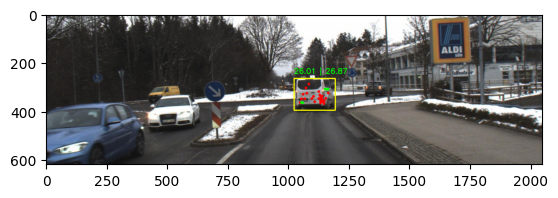

In [57]:
fuse_camera_lidar_radar(camera_image_rgb,lidar_df,radar_df,'000133','truck')

# Dataset Creation

In [ ]:
radar_dir = []
lidar_dir = []
IDs = []
for x in camera:
    ID = x[:6]
    radar_file = ID + '.txt'
    lidar_file = ID + '.txt'
    IDs.append(ID)
    radar_dir.append(radar_file)
    lidar_dir.append(lidar_file)
    lidar_df = pd.read_csv(f'Lidar/{lidar_file}',delim_whitespace=True)

# Cars

In [101]:
cars = os.listdir('Cars')

In [102]:
radar_dir_cars = []
lidar_dir_cars = []
IDs_cars = []
for x in cars:
    ID = x[:6]
    radar_file = ID + '.txt'
    lidar_file = ID + '.txt'
    IDs_cars.append(ID)
    radar_dir_cars.append(radar_file)
    lidar_dir_cars.append(lidar_file)

In [ ]:
for i in range(len(cars)):
    image = cars[i]
    lidar_file = lidar_dir_cars[i]
    radar_file = radar_dir_cars[i]
    ID = IDs_cars[i]
    lidar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/{lidar_file}',delim_whitespace=True)
    radar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/{radar_file}',delim_whitespace=True)
    camera_image_rgb = cv2.cvtColor(cv2.imread(f'dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{image}'), cv2.COLOR_BGR2RGB)
    fuse_camera_lidar_radar(camera_image_rgb,lidar_df,radar_df,ID,'car')

# Buses

In [ ]:
buses = os.listdir('Buses')
radar_dir_buses = []
lidar_dir_buses = []
IDs_buses = []
for x in buses:
    ID = x[:6]
    radar_file = ID + '.txt'
    lidar_file = ID + '.txt'
    IDs_buses.append(ID)
    radar_dir_buses.append(radar_file)
    lidar_dir_buses.append(lidar_file)

for i in range(len(buses)):
    image = buses[i]
    lidar_file = lidar_dir_buses[i]
    radar_file = radar_dir_buses[i]
    ID = IDs_buses[i]
    lidar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/{lidar_file}',delim_whitespace=True)
    radar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/{radar_file}',delim_whitespace=True)
    camera_image_rgb = cv2.cvtColor(cv2.imread(f'dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{image}'), cv2.COLOR_BGR2RGB)
    fuse_camera_lidar_radar(camera_image_rgb,lidar_df,radar_df,ID,'bus')

# Trucks

In [ ]:
trucks = os.listdir('Trucks')
radar_dir_trucks = []
lidar_dir_trucks = []
IDs_trucks = []
for x in trucks:
    ID = x[:6]
    radar_file = ID + '.txt'
    lidar_file = ID + '.txt'
    IDs_trucks.append(ID)
    radar_dir_trucks.append(radar_file)
    lidar_dir_trucks.append(lidar_file)

for i in range(len(trucks)):
    image = trucks[i]
    lidar_file = lidar_dir_trucks[i]
    radar_file = radar_dir_trucks[i]
    ID = IDs_trucks[i]
    lidar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/{lidar_file}',delim_whitespace=True)
    radar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/{radar_file}',delim_whitespace=True)
    camera_image_rgb = cv2.cvtColor(cv2.imread(f'dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{image}'), cv2.COLOR_BGR2RGB)
    fuse_camera_lidar_radar(camera_image_rgb,lidar_df,radar_df,ID,'truck')

# Evaluation of results

# Trucks

In [132]:
truck_radar_estimations = [45.93, 45.33, 45.12, 44.51, 43.96, 43.17, 42.17, 41.79, 40.41, 22.83, 21.61, 19.09, 13.55, 24.2, 22.77, 13.36, 13.05, 11.04, 11.06, 10.13, 10.04, 9.87, 7.31, 10.72, 10.58, 8.81, 11.83, 10.66, 11.15, 12.37, 11.27, 11.91, 10.5, 9.3, 9.56, 9.33, 9.14, 29.33, 26.01, 25.74, 25.03, 24.38, 25.03, 23.76, 23.49, 22.94, 15.89, 18.47, 9.79, 9.36, 8.73, 8.61, 8.43, 9.65, 14.85, 22.06, 21.7, 26.24, 16.57]

In [143]:
truck_frames = os.listdir('Final Frames/Trucks')
truck_actual_distances = []
i = 0
for x in truck_frame_ids:
    pseudo = []
    comparison = []
    json_file = x + '.json'
    with open(f'dataset_astyx_hires2019/dataset_astyx_hires2019/groundtruth_obj3d/{json_file}') as f:
           gt = json.load(f)
           for x in range(len(gt['objects'])):
               y = round(gt['objects'][x]['center3d'][0],2)
               pseudo.append(y)
           for x in pseudo:
               comparison.append(abs(x-estimates[i]))
           index = comparison.index((min(comparison)))
           truck_actual_distances.append(pseudo[index])
    i+=1
truck_errors = []
for i in range(len(estimates)):
    error = abs(truck_radar_estimations[i] - truck_actual_distances[i])
    truck_errors.append(error)
np.mean(truck_errors)

1.6911864406779666

# Cars

In [142]:
car_frame_ids = []
for x in cars:
    car_frame_ids.append(x[:6])
car_actual_distances = []

i = 0
for x in car_frame_ids:
    pseudo = []
    comparison = []
    json_file = x + '.json'
    with open(f'dataset_astyx_hires2019/dataset_astyx_hires2019/groundtruth_obj3d/{json_file}') as f:
           gt = json.load(f)
           for x in range(len(gt['objects'])):
               y = round(gt['objects'][x]['center3d'][0],2)
               pseudo.append(y)
           for x in pseudo:
               comparison.append(abs(x-car_radar_estimations[i]))
           index = comparison.index((min(comparison)))
           car_actual_distances.append(pseudo[index])
    i+=1

car_errors = []
for i in range(len(car_radar_estimations)):
    error = abs(car_radar_estimations[i] - car_actual_distances[i])
    car_errors.append(error)
np.mean(car_errors)

1.4698560111597436

# Buses

In [158]:
bus_actual_distances = []
bus_frame_ids = []
for x in buses:
    bus_frame_ids.append(x[:6])
bus_actual_distances = []
i = 0
for x in bus_frame_ids:
    pseudo = []
    comparison = []
    json_file = x + '.json'
    with open(f'dataset_astyx_hires2019/dataset_astyx_hires2019/groundtruth_obj3d/{json_file}') as f:
           gt = json.load(f)
           for x in range(len(gt['objects'])):
               y = round(gt['objects'][x]['center3d'][0],2)
               pseudo.append(y)
           for x in pseudo:
               comparison.append(abs(x - bus_radar_estimations[i]))
           index = comparison.index((min(comparison)))
           bus_actual_distances.append(pseudo[index])
    i+=1

bus_errors = []
for i in range(len(bus_radar_estimations)):
    error = abs(bus_radar_estimations[i] - bus_actual_distances[i])
    bus_errors.append(error)
np.mean(bus_errors)

2.4811230820034917

In [159]:
average_error = (np.mean(car_errors) + np.mean(bus_errors) + np.mean(truck_errors)) / 3

In [160]:
average_error

1.8807218446137342